# ΙΑΚΩΒΟΣ ΕΥΔΑΙΜΩΝ p3130059 ΤΜΗΜΑ: ΠΛΗΡΟΦΟΡΙΚΗΣ

# Clustering and Classification of MEPs' Tweets

You will investigate a dataset of tweets made by Members of the European Parliament. You will use data collected by Darko Cherepnalkoski, Andreas Karpf, Igor Mozetič, and Miha Grčar for their paper [Cohesion and Coalition Formation in the European Parliament: Roll-Call Votes and Twitter Activities](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0166586) (while you are at it, why not read the paper as well?).

This assignment is based on an original assignment by Ioannis Pavlopoulos (postdoc researcher) and Vasiliki Kougia (PhD candidate at AUEB).

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr


In [7]:
import numpy as np
import datetime as dt 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
import math
import tweepy
from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

## Data Preparation

* Get the dataset from <https://www.clarin.si/repository/xmlui/handle/11356/1071>.

* You will use the `retweets.csv` file.

* Keep only the records for which the language of the original tweet is in English.

* Get the text of the *original tweet* and add it to the dataset as an extra column. Use the Tweeter API to get the text (e.g., with Tweepy). In order not to run into rate limits you can ask for multiple tweets with one call.

* Keep only the records for which you were able to download the tweet text.

* Group the records by the European group of the MEP that posted the original tweet. If you see that there are groups with very few tweets (less than 50), drop them. 

Διάβασμα csv retweets μέσω του pandas

In [2]:
filename = 'Dataset/retweets.csv'
data = pd.read_csv(filename)

In [3]:
data.head()

,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,...,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang
0,249601317,papadimoulis,28586,Dimitrios PAPADIMOULIS,0,GUE-NGL,11,GRC,33248043,EvaKaili,...,Eva KAILI,1,S&D,11,GRC,Tue Nov 01 12:11:39 +0000 2011,131342637201506304,Sat Jun 27 14:17:28 +0000 2015,614799711309012992,el
1,249601317,papadimoulis,28586,Dimitrios PAPADIMOULIS,0,GUE-NGL,11,GRC,33248043,EvaKaili,...,Eva KAILI,1,S&D,11,GRC,Sun Feb 05 07:45:30 +0000 2012,166064894725206017,Wed Jun 17 12:04:06 +0000 2015,611142270809731072,el
2,217749896,MLP_officiel,28210,Marine LE PEN,7,ENL,9,FRA,498983436,SteeveBriois,...,Steeve BRIOIS,7,ENL,9,FRA,Sun Mar 25 14:47:16 +0000 2012,183928038675849216,Tue Nov 24 09:58:19 +0000 2015,669092676000686080,fr
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,...,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en
4,217749896,MLP_officiel,28210,Marine LE PEN,7,ENL,9,FRA,3065992036,DominiqueBilde,...,Dominique BILDE,7,ENL,9,FRA,Wed May 15 17:43:25 +0000 2013,334725721853407232,Mon May 25 12:36:41 +0000 2015,602815550473904128,fr


Κρατάμε μόνο τα αγγλικά tweets από το dataframe

In [4]:
en_tweets = data[data["lang"]=="en"]
print(en_tweets.shape)
en_tweets.head()

(13796, 21)


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,...,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,...,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en
5,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,...,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en
11,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,...,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en
12,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,...,Margot PARKER,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en
13,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,...,Nigel FARAGE,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en


Εδώ κρατάμε ουσιαστικά παίρνουμε τα και τα εισάγουμε σε μία λίστα τα id των original tweets, τα οποία χρησιμοποιούμε αργότερα για να αναζητήσουμε την ανάρτησή τους

In [5]:
id_list = en_tweets['origTweetId'].values.tolist()

Εδώ κάνουμε την σύνδεση χρησιμοποιώντας τα credentials μας που είναι στο αρχείο twitter_config.py και κάνουμε import το αρχείο ώστε μετά να κάνουμε την σύνδεσή μας και να ανακτήσουμε τα text από τα tweets μέσω του Tweepy API

In [7]:
from twitter_config import config
auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Μέσω της μεθόδου statuses_lookup() του API ανακτούμε τα κατάλληλα texts των tweets σύμφωνα με το id που έχουν. Η μέθοδος paginate μας βοηθάει ώστε να μην έχουμε θέματα με το rate_limit και με το όριο των tweets που μπορεί να ανακτήσει η μέθοδος statuses_lookup() η οποία μπορεί να ανακτάει περίπου μέχρι 100 ανά κλήση της. Τα ανακτηθέντα tweets αποθηκεύονται προς το παρόν σε ενα dictionary με key το id του tweet και value το text. Θεώρησα ότι κάθε id αντιστοιχεί σε ένα και μόνο σε ένα text 

In [8]:
import itertools
def paginate(iterable, page_size):
    while True:
        i1, i2 = itertools.tee(iterable)
        iterable, page = (itertools.islice(i1, page_size, None),
                list(itertools.islice(i2, page_size)))
        if len(page) == 0:
            break
        yield page

tweet_txt = {}
id_tweet = []
for page in paginate(id_list, 100):
    results = api.statuses_lookup(page)
    for result in results:
        tweet_txt[result.id]=result.text
        id_tweet.append(result.id)
        #print (result.text)
tweet_txt

{519050739642286080: "Lord Hill's written answers to EP are now on my blog. No transparency on his lobbying past. Shame! http://t.co/OT7TGKGDek #EPhearings2014",
 519139901359783936: "Our @SebDance asks @ABratusek about global climate talks.'Pls tell us how you will push a strong &amp; unified EU voice?' http://t.co/qR484dM9m9",
 518024241024073728: 'I write for @LabourList Tory threat to Court of #HumanRights "would replace rule of law with rule of mob." http://t.co/79DGCT8t2E @LabourCHR',
 519109106272317440: '“@Ashleyfoxmep: and named her party "the Alliance of Alenka Bratusek! #EPhearings2014 Mrs Bratusek says #Bratusek',
 518721908951769088: 'Good luck to @TheProgressives in Bulgaria today @EuroLabour',
 517735072754302976: "As EP does not provide coffee in meetings Commissioner designate Vestager has invited us for it. We'll approve her  #Vestager #EPHearing2014",
 500600838419935232: "Robert Halfon raising issue of illegal traveller sites - if UKIP had done it he'd have called u

Εδώ ενσωματώνουμε τα από τα dictionaries τα text στο dataframe ταιριάζοντας το key του dictionary με τις τιμές της στήλης origTweetId 

In [9]:
en_tweets['tweetText'] = en_tweets['origTweetId'].apply(lambda x: tweet_txt.get(x))
en_tweets.head()

C:\Users\IAKOVOS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,...,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,tweetText
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,...,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en,Euro Parliament votes overwhelmingly to reject...
5,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,...,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en,"US have one currency, one Central Bank and one..."
11,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,...,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en,More jobs for young people is my top priority ...
12,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,...,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
13,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,...,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."


Στο συγκεκριμένο σημείο "πετάμε" από το dataframe τις εγγραφές για τις οποίες δεν καταφέραμε να βρούμε ή γενικά να ανακτήσουμε τα κείμενα από τα tweets

In [10]:
en_tweets.dropna(subset=['tweetText'],inplace=True)
en_tweets.shape

C:\Users\IAKOVOS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(12926, 22)

Τέλος, "γκρουπάρουμε" τις εγγραφές σύμφωνα με το feature European group of the MEP(origMepGroupId) και αφαιρούμε αυτά τα γκρουπ που έχουν "τουιτάρει" λιγότερα από 50 tweets 

In [11]:
grouped = en_tweets.groupby('origMepGroupId').filter(lambda x: len(x) >= 50).groupby('origMepGroupId')

Εδώ ουσιαστικά επιβεβαιώνουμε ότι το groupby μας είναι σωστό 

In [13]:
print('Number of groups: '+str(len(grouped)))
gbp =en_tweets.groupby(['origMepGroupId']).count()
gbp

Number of groups: 7


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,...,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,tweetText
origMepGroupId,,,,,,,,,,,,,,,,,,,,,
0,353,353,353,353,353,353,353,353,353,353,...,353,353,353,353,353,353,353,353,353,353
1,3039,3039,3039,3039,3039,3039,3039,3039,3039,3039,...,3039,3039,3039,3039,3039,3039,3039,3039,3039,3039
2,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,...,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195
3,1854,1854,1854,1854,1854,1854,1854,1854,1854,1854,...,1854,1854,1854,1854,1854,1854,1854,1854,1854,1854
4,2098,2098,2098,2098,2098,2098,2098,2098,2098,2098,...,2098,2098,2098,2098,2098,2098,2098,2098,2098,2098
5,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,...,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102
6,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261,...,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261
7,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## Clustering

* Use k-means to cluster the tweets based on their text.

* The tweet texts must be converted to a format suitable for k-means, bag of word matrices or tf-idf matrices.

  * That means that you will need to use a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or a [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 
  
  * You may want to strip accents, and convert everything to lowercase. 
  
  * Use `min_df=10` and `max_df=50`.
  
  * Remove all English stopwords.
  
  * You may experiment with additional ideas about how best to tokenize etc.

* Use both the elbow method and the silhouette score to investigate the best number of clusters. Settle on the best number of clusters. 

* Visualize the clusters using Yellowbrick's [InterclusterDistance](https://www.scikit-yb.org/en/latest/api/cluster/icdm.html).
  
* Then, investigate the clusters by finding the most important features in each cluster. To do that, you will find the cluster center of each cluster, get the top $k$ dimensions (for $k$ say 10, 20, 30, ..., your choice) and print them out. The top $k$ dimensions are the $k$ dimensions with the biggest value in the cluster center. Do they make any sense?

Παρακάτω βρίσκουμε τις λέξεις με συχνότητα πάνω από 500 σε όλα τα tweets. Θα χρησιμοποιήσουμε αυτή την πληροφορία και προσθέσαμε επιπλέον λέξεις πιθανές stop words για να τα προσθέσουμε σε μία λίστα που θα ουσιαστικά δημιουργούμε την δικιά μας λίστα με stopwords 

In [14]:
fw=pd.Series(' '.join(en_tweets.tweetText).split()).value_counts()
fw[fw>500]

to           6744
the          6615
in           4578
of           4439
on           3276
for          3199
a            2611
and          2608
is           2143
&amp;        1877
EU           1844
with         1831
be           1041
-            1018
that          978
at            953
are           919
by            903
from          902
I             893
not           861
will          842
we            811
have          739
this          711
European      658
as            643
The           633
our           627
We            625
@EPPGroup     608
has           591
about         576
it            570
you           533
my            531
dtype: int64

In [15]:
#create my own list of stopwords
stop=['the','of','and','to', 'in', 'a', 'that', 'he', 'was', 'it', 'his', 'is','with', 'as', 'i', 'had', 'for', 'at', 'by', 'on','they','were','out','am','not','amn\'t','aren\'t','isn\'t','wasn\'t','were\'t']
val =fw[fw>500].index.tolist()
val = [x for x in val if x != '@EPPGroup']
val = [x.lower() for x in val]
my_stopwords=stop+val
my_stopwords=list(set(my_stopwords))

Εδώ φτιάχνουμε ένα δικό μας analyzer κάνοντας tokenization lemmatization και το preprocessing

In [9]:
# create a custom analyzer class
import spacy
from html import unescape
class MyAnalyzer(object):

    

    # load spaCy's english model and define the tokenizer/lemmatizer

    def __init__(self):

        spacy.load('en')

        self.lemmatizer_ = spacy.lang.en.English()

        

    # allow the class instance to be called just like

    # just like a function and applies the preprocessing and

    # tokenize the document

    def __call__(self, doc):

        doc_clean = unescape(doc).lower()

        tokens = self.lemmatizer_(doc_clean)

        return([token.lemma_ for token in tokens])

    

analyzer = MyAnalyzer()

custom_vec =  TfidfVectorizer(strip_accents='unicode', lowercase=True, analyzer=analyzer, stop_words='english',token_pattern=r"(?u)\b[a-z][\w+']+\b", ngram_range=(1,2),  max_df=50, min_df=10)



Στο συγκεκριμένο σημείο χρησιμοποιούμε το TfidfVectorizer ώστε να μπορέσουμε να δημιουργήσουμε το tfidf των tweets που ανακτήσαμε προηγουμένως. Τα μετατρέπουμε όλα σε lowercase, χρησιμοποιούμε τον analyzer που παρέχεται από αυτό το module του sklearn και χρησιμοποιούμε επίσης της stop word list που παρέχεται. Επίσης, θέτουμε ένα  συγκεκριμένο token pattern ώστε να πάρουμε τις λέξεις που δεν περιέχουν αριθμούς και επιπλέον θέτουμε και το ngram_range έτσι ώστε να παίρνουμε μέχρι δίγραμμα. Τέλος, θέτουμε το max_df και min_df σύμφωνα με τους αριθμούς που μας δίνονται από την εκφώνηση και αφού σετάρουμε αυτές τις παραμέτρους βρίσκουμε το tfidf για τα tweets μας

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = en_tweets['tweetText'].values.tolist()
vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, analyzer='word', stop_words='english',token_pattern=r"(?u)\b[a-z][\w+']+\b", ngram_range=(1,2),  max_df=50, min_df=10)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)

['abduction', 'able', 'abroad', 'absolutely', 'absolutely right', 'absurd', 'abuse', 'accept', 'acceptable', 'accepted', 'accession', 'according', 'account', 'accountability', 'achieve', 'achievements', 'acting', 'actions', 'activists', 'actually', 'add', 'addressing', 'admits', 'adopt', 'advance', 'advice', 'affairs', 'affected', 'afraid', 'africa', 'african', 'afternoon', 'age', 'agency', 'ago', 'agreed', 'agreements', 'agrees', 'agriculture', 'agst', 'aids', 'air', 'air quality', 'al', 'alan', 'alan johnson', 'alde4growth', 'aldecongress', 'aldegroup http', 'aldeparty', 'allianceecr', 'allow', 'allowed', 'allowing', 'alongside', 'alternative', 'amazing', 'ambassador', 'ambition', 'ambitious', 'amendment', 'amendments', 'american', 'amjadbashirmep', 'amp eu', 'amp families', 'amp growth', 'amp human', 'amp middleton', 'amp royton', 'amp security', 'amp uk', 'amp vote', 'amp work', 'anagomesmep', 'analysis', 'andreas_schwab', 'andreas_schwab c_stihler_mep', 'angela', 'angela merkel', 

Εδώ εμφανίζουμε το vocabulary που δημιουργήθηκε με την κάθε λέξη με το αντίστοιχο tfidf της

In [17]:
vectorizer.vocabulary_

{'reject': 1838,
 'reason': 1800,
 'parliament votes': 1612,
 'vote ukip': 2362,
 'currency': 462,
 'central': 297,
 'bank': 166,
 'priority': 1722,
 'sweden': 2139,
 'young people': 2458,
 'ecr': 619,
 'confirmed': 399,
 'post': 1694,
 'chief': 326,
 'presidency': 1709,
 'raising': 1786,
 'called': 261,
 'ignore': 1110,
 'lies': 1316,
 'stands': 2067,
 'nhs http': 1532,
 "i'll": 1101,
 'candidates': 271,
 'environment': 673,
 'ask': 121,
 'presentation': 1707,
 'hill': 1059,
 'keen': 1242,
 'listen': 1328,
 'hungary': 1098,
 'model': 1473,
 'intelligence': 1155,
 'lord': 1343,
 'ill': 1112,
 'lets': 1303,
 'ashleyfoxmep': 120,
 'example': 795,
 'answers': 94,
 'committed': 371,
 'fast': 847,
 'fully': 929,
 'directive': 564,
 'decision': 509,
 'asks': 124,
 'industrial': 1135,
 'tackle': 2148,
 'possible': 1693,
 'smes': 2019,
 'financial': 864,
 'contributions': 419,
 'agreed': 35,
 'debt': 504,
 'eu budget': 716,
 'summary': 2113,
 'disappointed': 568,
 "didn't": 549,
 'answer': 93,

In [18]:
print(X.shape)

(12926, 2465)


Στο συγκεκριμένο σημείο χρησιμοποιούμε την elbow μέθοδο για να υπολογήσουμε το βέλτιστο αριθμό από clusters που θα χρησιμοποιήσουμε στον kmeans. Ψάχνουμε ανάμεσα στο διάστημα από [2,30]. Έτσι κι αλλιώς ξέρουμε ότι έχουμε 9 πολιτικά κόμματα οπότε ίσα ίσα ψάχνουμε σε ένα αρκετά μεγάλο διάστημα

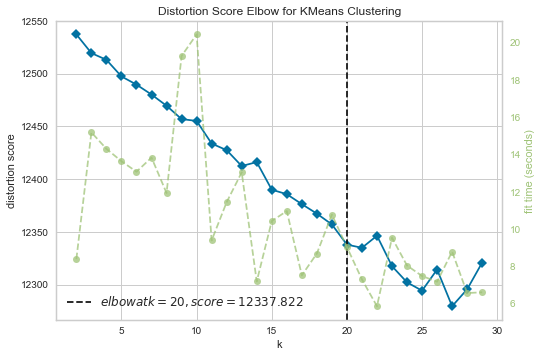

In [23]:
#elbow method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(2,30))

visualizer.fit(X)
visualizer.show()

Στο συγκεκριμένο σημείο χρησιμοποιούμε την silhouete μέθοδο για να υπολογήσουμε το βέλτιστο αριθμό από clusters που θα χρησιμοποιήσουμε στον kmeans. Ψάχνουμε ανάμεσα στο διάστημα από [2,29]. Έτσι κι αλλιώς ξέρουμε ότι έχουμε 9 πολιτικά κόμματα οπότε ίσα ίσα ψάχνουμε σε ένα αρκετά μεγάλο διάστημα

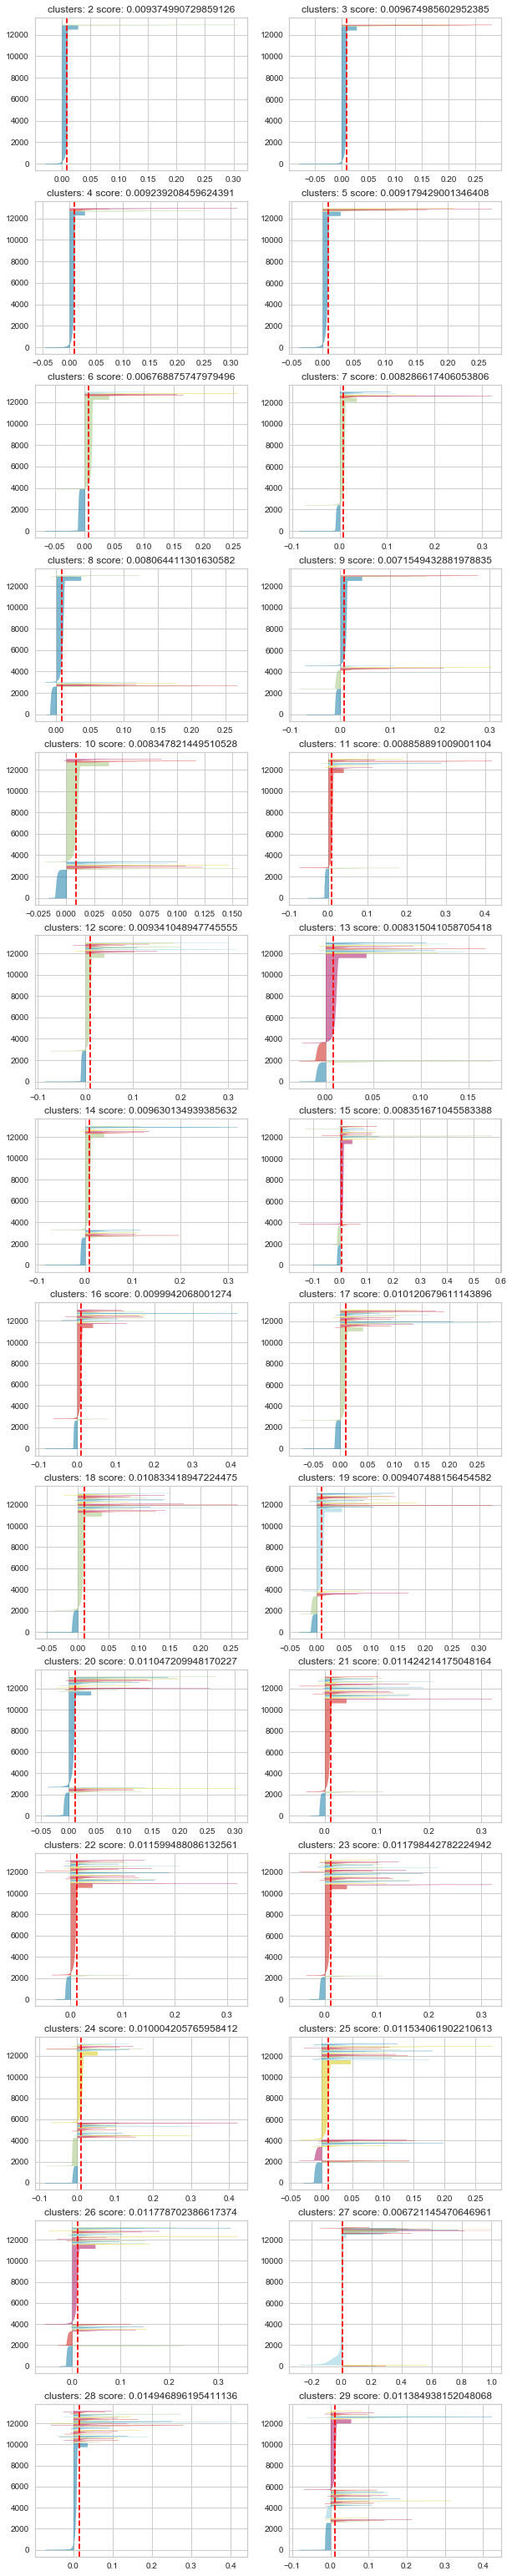

In [21]:
#silhouete method
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
plt.figure(figsize=(2 * 5,  15 * 4))

scores = {}
for n_clusters in range(2, 30):
    plt.subplot(15, 2, n_clusters-1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

Εδώ εκτυπώνουμε τον αριθμό των clusters σε φθίνουσα σειρά σύμφωνα με αυτόν τον αριθμό που μας θεωρεί η silhouete μέθοδος ως πιο βέλτιστο

In [22]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(28, 0.014946896195411136),
 (23, 0.011798442782224942),
 (26, 0.011778702386617374),
 (22, 0.011599488086132561),
 (25, 0.011534061902210613),
 (21, 0.011424214175048164),
 (29, 0.011384938152048068),
 (20, 0.011047209948170227),
 (18, 0.010833418947224475),
 (17, 0.010120679611143896),
 (24, 0.010004205765958412),
 (16, 0.0099942068001274),
 (3, 0.009674985602952385),
 (14, 0.009630134939385632),
 (19, 0.009407488156454582),
 (2, 0.009374990729859126),
 (12, 0.009341048947745555),
 (4, 0.009239208459624391),
 (5, 0.009179429001346408),
 (11, 0.008858891009001104),
 (15, 0.008351671045583388),
 (10, 0.008347821449510528),
 (13, 0.008315041058705418),
 (7, 0.008286617406053806),
 (8, 0.008064411301630582),
 (9, 0.0071549432881978835),
 (6, 0.006768875747979496),
 (27, 0.006721145470646961)]

Εδώ εφαρμόζουμε τον kmeans και παρακάτω φαίνονται οι ομάδες που δημιουργούνται. Επιλέξαμε τελικά ως αριθμό ομάδων το 20 το οποίο δόθηκε σε ένα τρέξιμο της elbow μεθόδου και σε ένα από τα πολλά της silhouete μεθόδου

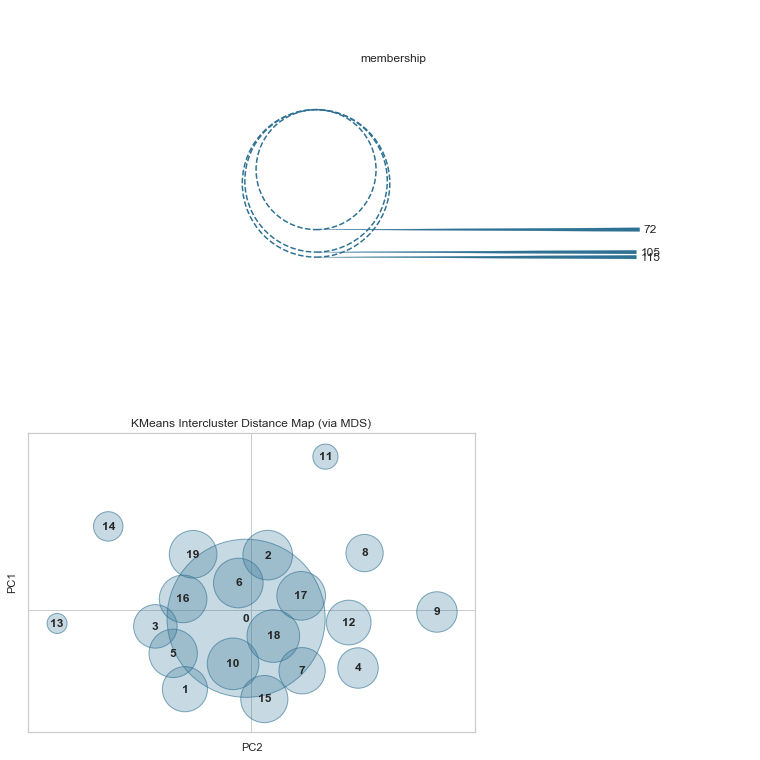

In [27]:
from yellowbrick.cluster import InterclusterDistance
#9,14,20,22,26,28
clsts=20
# Instantiate the clustering model and visualizer
model = KMeans(clsts, random_state=0)
visualizer = InterclusterDistance(model, legend=True, legend_loc='lower left', legend_size=10.0)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Τέλος, εκτυπώνουμε και βρίσκουμε τα 10,20 και 30 features που έχουν μεγαλύτερο βάρος για τον υπολογισμό των κέντρων της κάθε συστάδας. Της κάθε ομάδας τα 10 είτε 20 είτε 30 πιο σημαντικά features δείχνουν μία κοινή φρασεολογία, θεματολογία και ιδεολογία που συνηθίζει το κάθε κοινοβουλευτικό μέλος ενός συγκεκριμένου κόμματος να χρησιμοποιεί στα tweets του. 

In [28]:
centers = visualizer.cluster_centers_
kp=[10, 20, 30]
for k in kp:
    print("Top "+ str(k) +" terms per cluster:")
    order_centroids = visualizer.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(clsts):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :k+1]:
            print(' %s' % terms[ind], end='')
            print()

Top 10 terms per cluster:
Cluster 0: scotland
 statement
 http http
 debt
 responsibility
 hollande
 decision
 miriamdalli
 chance
 soon
 equality
Cluster 1: freesavchenko
 ukrainian
 demand
 savchenko
 freesavchenko http
 immediate release
 nadia
 immediate
 nadia savchenko
 europe4ukraine
 abduction
Cluster 2: benefits
 fundamental
 consumers
 fundamental rights
 end roaming
 roaming charges
 charges
 forget
 business usual
 businesses
 usual
Cluster 3: marietjeschaake
 safety
 highest
 senficon
 road
 level
 weidenholzer
 breakfast
 norway
 lives
 davidmartinmep
Cluster 4: local
 proper
 great day
 newspaper
 admits
 gt http
 gov
 candidates
 turns
 crowd
 recent
Cluster 5: tackle
 challenges
 priority
 young people
 opportunities
 leadership
 dutch
 smes
 waste
 initiatives
 including
Cluster 6: house
 signed
 obama
 sanctions
 commons
 digital agenda
 dieselgate
 car
 petition
 ii
 inquiry committee
Cluster 7: paper
 worth
 page
 mistake
 merkel's
 eppgroup just
 just adopted
 fac

 understand
 value
 created
 current
 systems
 we're eu
 set
 watching
Cluster 17: kajakallas
 syedkamall
 final
 sorry
 chamber
 ashleyfoxmep
 positions
 hennavirkkunen
 personal
 david_cameron
 dieselgate meeting
 tomorrow's
 right know
 ed
 victims families
 dieselgate
 sent
 mep's
 ge2015
 vat
 sophieintveld
 stevenshelga
 conservatives
 language
 eppgroup https
 marietjeschaake
 legislation
 live http
 directive
 hard work
 speed
Cluster 18: jyrkikatainen
 comilara
 riga
 pablozalba
 bureau
 josephdaul
 tomvdkendelaere
 eppgroup bureau
 tonoepp
 young members
 egardini
 bureau meeting
 grossetetef
 members network
 eppgroup study
 study days
 salvocicu
 eppgroup young
 study
 network
 maxsalini
 eppgroup meeting
 mtg
 eastern
 tomzdechovskyep
 efsi
 fjellner
 kgeorgievaeu
 glandsbergis
 reform2grow
 milan
Cluster 19: community
 andreas_schwab
 lvnistelrooij
 charanzova
 rozathun
 delcastillop
 charanzova http
 andreas_schwab c_stihler_mep
 radicalisation
 dantinicola
 fascinating


## Classification

* Train at least two algorithms to learn to classify an unseen tweet. The target variable should be the political party of the original poster and the training features should be the original tweet's text.

* You should split your data to training and testing datasets, try the different algorithms with cross validation on the training dataset, and find the best hyperparameters for the best algorithm. The best hyperparameters for the construction of the bag of words or tf-idf matrices for classification are not necessarily the same with those you used for k-means.

* Report your scores; once you find the best algorithm and the best hyperparameters, report the score on the test data.

* To gauge the efficacy of the algorithm, report also the results of a baseline classifier, using, for instance, scikit-learn's [`DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html).

Χρησιμοποιούμε ένα dictionary στο οποίο αποθηκεύουμε τον αριθμό του κάθε πολιτικού κόμματος με αυτό του ονόματός του

In [4]:
#name of parties with code of parties
pn = pd.Series(en_tweets.origMepGroupShort.values,index=en_tweets.origMepGroupId).to_dict()
pn

{6: 'EFDD',
 1: 'S&D',
 5: 'ECR',
 3: 'ALDE',
 4: 'EPP',
 2: 'Greens-EFA',
 0: 'GUE-NGL',
 7: 'ENL',
 8: 'NI'}

Πρώτα, παίρνουμε τα tweets και τις κατηγορίες που θέλουμε να προβλέψουμε από το dataframe(δηλαδή τους κωδικούς των πολιτικών κομμάτων). Έπειτα, κάνουμε split το dataset σε train set και test set αφιερώνοντας το 25% του για test

In [5]:
#split your data to training and testing datasets
from sklearn.model_selection import train_test_split
# Get dataset with only the  two attributes
X, y = en_tweets['tweetText'], en_tweets['origMepGroupId']
# Split the dataset into a training and a testing set
# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9699,) (9699,)
(3233,) (3233,)


Εδώ, βλέπουμε κάτι πολύ σημαντικό που πρέπει να παρατηρήσουμε. Την ισορροπία των κλάσεων σε όλο το dataframe, έπειτα στο train dataset και τέλος στο test dataset. Αυτό το κομμάτι είναι σημαντικό για να διαπυστώσουμε ότι λογικά οι κατηγορίες 7 και ειδικά η 8 λογικά δεν θα τις "μάθουν" ποτέ οι αλγόριθμοι που θα χρησιμοποιήσουμε παρακάτω, λόγω των λίγων δεδομένων εκπαίδευσης που υπάρχουν σε αυτές τις 2 κατηγορίες

In [5]:
#BALANCE OF 9 CLASSES
print('Dataframe instances of every class:')
#print(en_tweets['origMepGroupId'].value_counts()/en_tweets.shape[0])
print(en_tweets['origMepGroupId'].value_counts())
print()
print('Train dataset instances of every class:')
#print(y_train.value_counts()/y_train.shape[0])
print(y_train.value_counts())
print()
print('Test dataset instances of every class:')
#print(y_test.value_counts()/y_test.shape[0])
print(y_test.value_counts())

Dataframe instances of every class:
6    3261
1    3039
4    2104
3    1854
2    1195
5    1102
0     353
7      23
8       1
Name: origMepGroupId, dtype: int64

Train dataset instances of every class:
6    2422
1    2281
4    1585
3    1401
2     893
5     830
0     268
7      19
Name: origMepGroupId, dtype: int64

Test dataset instances of every class:
6    839
1    758
4    519
3    453
2    302
5    272
0     85
7      4
8      1
Name: origMepGroupId, dtype: int64


Στο συγκεκριμένο σημείο ουσιαστικά θα χρησιμοποιήσουμε τον Multinomial Naive Bayes Classifier και για να βρούμε τις κατάλληλες υπερπαραμέτρους του θα χρησιμοποιήσουμε το GridSearch το οποίο χρησιμοποιεί την cross validation μέθοδο kfold με kfolds=10. Αφού βρούμε τις κατάλληλες υπερπαραμέτρους θα εκπαιδεύσουμε τον αλγόριθμο με το train dataset και θα χρησιμοποιήσουμε το μοντέλο για να προβλέψουμε το test dataset 

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='unicode',lowercase=True, analyzer='word', stop_words='english',token_pattern=r"(?u)\b[a-z][\w+']+\b", ngram_range=(1,2))),
    ('clf', MultinomialNB()),
])
parameters = {
              'tfidf__min_df': (10,5,20,15),
              'tfidf__max_df': (50,100,40,150), 
              'clf__alpha': (0.1,0,1e-2, 1e-3,2,1.0)
             }

gs_clf = GridSearchCV(estimator=text_clf, param_grid=parameters,cv=10, n_jobs=-1,verbose=2)
gs_clf = gs_clf.fit(X_train, y_train)
print('Best score for data:', gs_clf.best_score_)
print()
print(gs_clf.best_estimator_)
print()
print(gs_clf.best_params_)
print()
print(gs_clf.cv_results_)
predicted = gs_clf.predict(X_test)
print()
print(gs_clf.get_params())

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  3.5min finished


Best score for data: 0.6655663296884671

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=150, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...se_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

{'clf__alpha': 0.1, 'tfidf__max_df': 150, 'tfidf__min_df': 5}

{'mean_fit_time': array([0.63904634, 0.5537863 , 0.60641801, 0.61913152, 0.57430129,
       0.57368026, 0.54938936, 0.53792551, 0.54760931, 0.53385632,
       0.57295487, 0.54535863, 0.54162388, 0.55272973, 0.52963409,
       0.54236231, 0.5386441 , 0.54142506, 0.55351534, 0.53531809,
       0.53312721, 0.54991143, 0.52015648, 0.54557548, 0.52107415,
       0.53079185, 0.5344224 , 0.52575233, 0.51997538, 0.5313935 ,
       0.52496226, 0.53183312, 0.5266288 , 

In [34]:
for doc, category, ct in zip(X_test, predicted, y_test):
    print('%r => %s | correct category => %s' % (doc, pn[category], pn[ct]))

'My Letter to @junckerEU @Avramopoulos on necessary EU response to #Parisattacks #Brusselsalert is online via alde.eu' => ALDE | correct category => ALDE
"We have to learn from this Greek thriller. A currency union without a political union isn't sustainable.Let's change Europe now #Greekcrisis" => ALDE | correct category => ALDE
'Bravo! #NoichlReport #GenderEquality Strategy 2015_2020 gets majority support in #EP \nA strong political message! http://t.co/kUjLHUlsXj' => ALDE | correct category => ALDE
'Controversial PNR file finally passed in the #EP @EP_Justice committee. Congrats @TimKirkhopeMEP and @EPPGroup shadow @AxelVossMdEP' => EPP | correct category => EPP
'#Merkel and #Hollande were allocated 15 minutes each for their EP speeches. She spoke 15min. He spoke 25 min. #discipline #MerkelHollande' => ECR | correct category => EPP
'Sun shines as I join #LarasArmy in Great #Yarmouth with fantastic @lara_norris @lisaroper12 @amy_le_rose @gylabour http://t.co/XKE1shlwf3' => EFDD | cor

'Net migration is now 300,000 per year. Normality before 1997 was between 30,000-50,000. #leaderslive #leadersdebate http://t.co/KmNrGxEl0f' => EFDD | correct category => EFDD
'Ethiopia Might Have Bought A Ton Of Surveillance Tech &amp; why we need smart export controls now! http://t.co/XXG5W6XdH9 via @motherboard' => ALDE | correct category => ALDE
'Good to see @EveningChron picking up in my work with @Justice1st1 @ClaudeMoraesMEP &amp; @ckyenge on dangers in #DRC https://t.co/6IHveRfQbz' => EFDD | correct category => S&D
"80,000 UK students are told they can't train as a nurse http://t.co/MyzG2Cu7pE via @MailOnline" => EFDD | correct category => EFDD
"Nice, many members of EU Parliament's Intergroup on Europe's Digital Agenda speaking in debate for an open internet #internetgovernance" => ALDE | correct category => ALDE
'Well earned teas and sarnies for my team after amazing positive canvass in #Middleton for @JohnBickleyUKIP. http://t.co/sC47pR9DpJ' => EFDD | correct category => EFD

Εδώ, εκτυπώνουμε το precision, accuracy, recall, f1-score καθώς και ένα συνολικό report με τα scores και τον confusion matrix για τις προβλέψεις που κάναμε στο test dataset χρησιμοποιώντας το παραπάνω μοντέλο που εκπαιδεύσαμε  

In [35]:
print('Accuracy Score : ' + str(accuracy_score(y_test,predicted)))

print('Precision Score : ' + str(precision_score(y_test,predicted, average=None)))

print('Recall Score : ' + str(recall_score(y_test,predicted, average=None)))

print('F1 Score : ' + str(f1_score(y_test,predicted, average=None)))
#The support is the number of occurrences of each class in y_true
print(metrics.classification_report(y_test, predicted,target_names=pn.values()))
metrics.confusion_matrix(y_test, predicted)

Accuracy Score : 0.6689356435643564
Precision Score : [0.81481481 0.64423077 0.67317073 0.58458244 0.6587156  0.67096774
 0.72689938 0.         0.        ]
Recall Score : [0.48351648 0.71657754 0.47586207 0.6        0.65036232 0.36363636
 0.87950311 0.         0.        ]
F1 Score : [0.60689655 0.67848101 0.55757576 0.59219089 0.65451231 0.47165533
 0.79595278 0.         0.        ]
              precision    recall  f1-score   support

        EFDD       0.81      0.48      0.61        91
         S&D       0.64      0.72      0.68       748
         ECR       0.67      0.48      0.56       290
        ALDE       0.58      0.60      0.59       455
         EPP       0.66      0.65      0.65       552
  Greens-EFA       0.67      0.36      0.47       286
     GUE-NGL       0.73      0.88      0.80       805
         ENL       0.00      0.00      0.00         4
          NI       0.00      0.00      0.00         1

   micro avg       0.67      0.67      0.67      3232
   macro avg      

C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Ana

array([[ 44,  20,   6,   6,   5,   1,   9,   0,   0],
       [  4, 536,  19,  56,  43,  13,  77,   0,   0],
       [  1,  60, 138,  36,  27,   1,  27,   0,   0],
       [  2,  58,  15, 273,  63,  11,  33,   0,   0],
       [  3,  66,  16,  59, 359,  10,  39,   0,   0],
       [  0,  41,   8,  22,  31, 104,  80,   0,   0],
       [  0,  48,   3,  14,  17,  15, 708,   0,   0],
       [  0,   2,   0,   1,   0,   0,   1,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

Στο συγκεκριμένο σημείο ουσιαστικά θα χρησιμοποιήσουμε τον Stochastic Gradient Descent Classifier και για να βρούμε τις κατάλληλες υπερπαραμέτρους του θα χρησιμοποιήσουμε το GridSearch το οποίο χρησιμοποιεί την cross validation μέθοδο kfold με kfolds=10. Αφού βρούμε τις κατάλληλες υπερπαραμέτρους θα εκπαιδεύσουμε τον αλγόριθμο με το train dataset και θα χρησιμοποιήσουμε το μοντέλο για να προβλέψουμε το test dataset 

In [7]:
#SGDClassifier
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='unicode',lowercase=True, analyzer='word', stop_words='english',token_pattern=r"(?u)\b[a-z][\w+']+\b", ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log', random_state=33,n_jobs=-1,early_stopping=True))
])
parameters = {
              'tfidf__min_df': (10,5),
              'tfidf__max_df': (50,100,150),
              'clf__penalty':('l2','l1','elasticnet'),
              'clf__alpha':(0.0001,0.001,0.00001),
              'clf__l1_ratio':(0.15,1,0.5),
              'clf__tol':(1e-3,1e-4),
              'clf__validation_fraction':(0.1,0.2)
             }


gs_clf = GridSearchCV(estimator=text_clf, param_grid=parameters,cv=5, n_jobs=-1,verbose=2)
gs_clf = gs_clf.fit(X_train, y_train)
print('Best score for data:', gs_clf.best_score_)
print()
print(gs_clf.best_estimator_)
print()
print(gs_clf.best_params_)
print()
print(gs_clf.cv_results_)
predicted = gs_clf.predict(X_test)
print()
print(gs_clf.get_params())

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 13.6min finished


Best score for data: 0.6494483967419321

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=150, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...om_state=33, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

{'clf__alpha': 1e-05, 'clf__l1_ratio': 0.15, 'clf__penalty': 'l2', 'clf__tol': 0.001, 'clf__validation_fraction': 0.1, 'tfidf__max_df': 150, 'tfidf__min_df': 5}

{'mean_fit_time': array([0.68137798, 0.68377752, 0.68897572, 0.71496763, 0.64738955,
       0.66938276, 0.76615062, 0.70776992, 0.69157505, 0.66798306,
       0.65938601, 0.64719005, 0.62339678, 0.62919488, 0.63579245,
       0.66098466, 0.63679242, 0.63779211, 0.64019151, 0.64299045,
       0.64199057, 0.68157849, 0.66978202, 0.66778307, 0.69257431,
       0.77


{'cv': 5, 'error_score': 'raise-deprecating', 'estimator__memory': None, 'estimator__steps': [('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern="(?u)\\b[a-z][\\w+']+\\b", tokenizer=None,
        use_idf=True, vocabulary=None)), ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=33, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))], 'estimator__tfidf': Tfidf

In [8]:
for doc, category, ct in zip(X_test, predicted, y_test):
    print('%r => %s | correct category => %s' % (doc, pn[category], pn[ct]))

"Tories want us to join an exclusive club with Belarus - Europe's last dictator! #defendourhumanrights http://t.co/P93raiq7WE" => S&D | correct category => S&D
'Great to have the fearless EU Competition Commissioner @vestager at the @ecrgroup tonight https://t.co/uqj3aUuxrU' => ECR | correct category => ECR
'On the M40 heading up to a public meeting in Oldham West &amp; Royton this evening, an exciting few days ahead.' => EFDD | correct category => EFDD
"It's a good thing that there is #Juncker proposal today &amp; we are no longer talking about millions but about #billions #ALDE4growth #jobs" => ECR | correct category => ALDE
"Here's why tomorrow will be Gordon Brown's eighteenth autumn statement. Cracking stuff from @DouglasCarswell: http://t.co/zRiza3XTlZ" => EFDD | correct category => EFDD
'Conservative MEPs secure EU support for small businesses over VAT rules - http://t.co/EXPg4G6e6f' => ALDE | correct category => ECR
'.@Ansip_EU: #DigitalSingleMarket is not only about money, it 

'European Parliament committee draws clear red lines for #TTIP concerning food and health http://t.co/LT9yijXL5j' => Greens-EFA | correct category => Greens-EFA
'Will be interested to hear the views of the leadership candidates on the EU and in particular how we win a referendum!' => EFDD | correct category => S&D
"EU Commission's going 2 vote on huge UK subsidies for nuclear industry 2morrow. So far 7 commissioners opposed. Now #Oettinger shifts 2 yes." => Greens-EFA | correct category => Greens-EFA
"Media &amp; other parties can try and skew what I've said but the truth is UKIP believes in Britain, and we fight for it: http://t.co/PxMD3N5cZN" => EFDD | correct category => EFDD
'.@EuroLabour MEPs say we #TrustTheTractor - a mark of quality British farm produce. #RedTractorWeek http://t.co/QS4MtzCqLw' => S&D | correct category => S&D
'Ministers have NOT "done all they can within EU rules to help Tata steel". They could scrap George Osborne\'s Carbon Floor Price.' => EFDD | correct cate

Εδώ, εκτυπώνουμε το precision, accuracy, recall, f1-score καθώς και ένα συνολικό report με τα scores και τον confusion matrix για τις προβλέψεις που κάναμε στο test dataset χρησιμοποιώντας το παραπάνω μοντέλο που εκπαιδεύσαμε 

In [10]:
print('Accuracy Score : ' + str(accuracy_score(y_test,predicted)))

print('Precision Score : ' + str(precision_score(y_test,predicted, average=None)))

print('Recall Score : ' + str(recall_score(y_test,predicted, average=None)))

print('F1 Score : ' + str(f1_score(y_test,predicted, average=None)))
#The support is the number of occurrences of each class in y_true
print(metrics.classification_report(y_test, predicted,target_names=pn.values()))
metrics.confusion_matrix(y_test, predicted)

Accuracy Score : 0.6786266625425301
Precision Score : [0.7173913  0.66912669 0.62008734 0.60822511 0.6641651  0.63507109
 0.75159915 1.         0.        ]
Recall Score : [0.38823529 0.7176781  0.47019868 0.62030905 0.68208092 0.49264706
 0.84028605 0.25       0.        ]
F1 Score : [0.50381679 0.69255251 0.53483992 0.61420765 0.6730038  0.55486542
 0.79347214 0.4        0.        ]
              precision    recall  f1-score   support

        EFDD       0.72      0.39      0.50        85
         S&D       0.67      0.72      0.69       758
         ECR       0.62      0.47      0.53       302
        ALDE       0.61      0.62      0.61       453
         EPP       0.66      0.68      0.67       519
  Greens-EFA       0.64      0.49      0.55       272
     GUE-NGL       0.75      0.84      0.79       839
         ENL       1.00      0.25      0.40         4
          NI       0.00      0.00      0.00         1

   micro avg       0.68      0.68      0.68      3233
   macro avg      

C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Ana

array([[ 33,  23,   5,   4,   5,   3,  12,   0,   0],
       [  5, 544,  32,  42,  49,  21,  65,   0,   0],
       [  2,  53, 142,  28,  36,   8,  33,   0,   0],
       [  2,  54,  14, 281,  52,  14,  36,   0,   0],
       [  3,  39,  21,  60, 354,  11,  31,   0,   0],
       [  0,  35,   9,  22,  18, 134,  54,   0,   0],
       [  1,  64,   6,  24,  19,  20, 705,   0,   0],
       [  0,   1,   0,   1,   0,   0,   1,   1,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0]], dtype=int64)

Στο συγκεκριμένο σημείο ουσιαστικά θα χρησιμοποιήσουμε τον XGBoost Classifier (μια ensemble μέθοδο) και για να βρούμε τις κατάλληλες υπερπαραμέτρους του θα χρησιμοποιήσουμε το GridSearch το οποίο χρησιμοποιεί την cross validation μέθοδο kfold με kfolds=5. Αφού βρούμε τις κατάλληλες υπερπαραμέτρους θα εκπαιδεύσουμε τον αλγόριθμο με το train dataset και θα χρησιμοποιήσουμε το μοντέλο για να προβλέψουμε το test dataset 

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='unicode',lowercase=True, analyzer='word', stop_words='english',token_pattern=r"(?u)\b[a-z][\w+']+\b",ngram_range=(1,2),min_df=5,max_df=150)),
    ('clf', xgb.XGBClassifier(objective ='binary:logistic')),
])
params = {
    'clf__learning_rate': [0.05,0.15,0.01,0.001],
    'clf__max_depth': [4,6,8], 
    'clf__reg_lambda': [0.5, 1, 2,0.1,0],
    'clf__n_estimators':[100,50,200]
}
#gs_clf = GridSearchCV(estimator=text_clf, param_grid=parameters,cv=10, n_jobs=-1)
gs_clf = GridSearchCV(estimator=text_clf, 
                   param_grid=params, 
                   n_jobs=-1, 
                   cv=5, 
                   scoring='neg_mean_absolute_error',
                   verbose=2,
                   iid=False,
                   refit=True)
gs_clf.fit(X_train,y_train)
print('Best score for data:', gs_clf.best_score_)
print()
print(gs_clf.best_estimator_)
print()
print(gs_clf.best_params_)
print()
print(gs_clf.cv_results_)
preds = gs_clf.predict(X_test)
print()
print(gs_clf.get_params())

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 73.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 111.2min finished


Best score for data: -0.9538202251749752

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=150, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...
       reg_lambda=0, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

{'clf__learning_rate': 0.15, 'clf__max_depth': 8, 'clf__n_estimators': 200, 'clf__reg_lambda': 0}

{'mean_fit_time': array([16.8795126 , 17.76102686, 17.6436645 , 17.54969568, 16.79474082,
        8.59640536,  8.55501842,  8.58840709,  8.66998072,  8.67078047,
       32.76594977, 33.11563621, 33.50216188, 33.43367243, 35.48506565,
       25.69572449, 25.13070841, 23.92842174, 24.16014709, 24.22812457,
       12.45315166, 12.16964388, 12.17504215, 12.2654129 , 12.30679941,
       46.32034426, 46.29155374, 46.8335463 , 46


{'cv': 5, 'error_score': 'raise-deprecating', 'estimator__memory': None, 'estimator__steps': [('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=150, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern="(?u)\\b[a-z][\\w+']+\\b", tokenizer=None,
        use_idf=True, vocabulary=None)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosi

In [12]:
for doc, category, ct in zip(X_test, preds, y_test):
    print('%r => %s | correct category => %s' % (doc, pn[category], pn[ct]))

"Tories want us to join an exclusive club with Belarus - Europe's last dictator! #defendourhumanrights http://t.co/P93raiq7WE" => S&D | correct category => S&D
'Great to have the fearless EU Competition Commissioner @vestager at the @ecrgroup tonight https://t.co/uqj3aUuxrU' => ECR | correct category => ECR
'On the M40 heading up to a public meeting in Oldham West &amp; Royton this evening, an exciting few days ahead.' => EFDD | correct category => EFDD
"It's a good thing that there is #Juncker proposal today &amp; we are no longer talking about millions but about #billions #ALDE4growth #jobs" => ALDE | correct category => ALDE
"Here's why tomorrow will be Gordon Brown's eighteenth autumn statement. Cracking stuff from @DouglasCarswell: http://t.co/zRiza3XTlZ" => EFDD | correct category => EFDD
'Conservative MEPs secure EU support for small businesses over VAT rules - http://t.co/EXPg4G6e6f' => EFDD | correct category => ECR
'.@Ansip_EU: #DigitalSingleMarket is not only about money, it

'An end to impunity of foreign drivers commiting traffic offences in Britain? Key vote in European Parliament tomorrow\nhttp://t.co/O1URIgl8iT' => EFDD | correct category => S&D
'Strong partners in the #Netherlands. Together pushing EU forward. Meeting @sybrandbuma @Esther_de_Lange @EPPGroup http://t.co/Net5Eu5zVo' => EPP | correct category => EPP
"We are friends and comrades even if some don't like it. We fight for a democratic Europe. Syriza Podemos Venceremos! http://t.co/Ndcm5DLetm" => GUE-NGL | correct category => GUE-NGL
'Now back To #Catania we are debating with Italian navy, #Easo, #Europol and #Frontex about the sea operations... http://t.co/2SLNmTgH54' => EFDD | correct category => EFDD
'Q&amp;A session at North Wales Conference with @BillDudleyNorth @DianeJamesMEP @MarkReckless https://t.co/Tv2d1Vb1RV' => EFDD | correct category => EFDD
"@nixon_tod @julie4nw @akhanmep the vote isn't on TTIP but on redlines. Need to set the agenda, not run from it" => S&D | correct category =

"I didn't expect this from an Independent columnist, but it's good to see people getting it finally: http://t.co/ac3u230064" => EFDD | correct category => EFDD
'So machen das die USA: Why It Takes Two Years for Syrian Refugees to Enter the U.S. #Migration https://t.co/oqI3U2D0at' => S&D | correct category => ENL
'The Labour Party: Still intent on bankrupting Britain (again) &gt;&gt; http://t.co/7rkUI1iPWY' => EPP | correct category => EFDD
'With Schengen falling apart and the security threat now very real, Mr. Juncker is being rewarded for failure. https://t.co/JJ2hW00ebM' => ECR | correct category => EFDD
'Union Solution in Med @peacenowisrael amb @Sebastia_Jordi i @jmterricabras @JillEvansMEP @ernestmaragall #Palestina http://t.co/GULuhbiiHk' => Greens-EFA | correct category => Greens-EFA
'The madness of the EU. Give 3 bil to Turkey, waive visa requirements, start open door policy onday @eucopresident says EU not ready for more' => EFDD | correct category => EFDD
'Today is the memori

Εδώ, εκτυπώνουμε το precision, accuracy, recall, f1-score καθώς και ένα συνολικό report με τα scores και τον confusion matrix για τις προβλέψεις που κάναμε στο test dataset χρησιμοποιώντας το παραπάνω μοντέλο που εκπαιδεύσαμε 

In [13]:
print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))

print('Precision Score : ' + str(precision_score(y_test,preds, average=None)))

print('Recall Score : ' + str(recall_score(y_test,preds, average=None)))

print('F1 Score : ' + str(f1_score(y_test,preds, average=None)))
#The support is the number of occurrences of each class in y_true
print(metrics.classification_report(y_test, preds,target_names=pn.values()))
metrics.confusion_matrix(y_test, preds)

Accuracy Score : 0.6650170120630993
Precision Score : [0.671875   0.65714286 0.71078431 0.70809249 0.69795918 0.61931818
 0.64618086 0.11111111 0.        ]
Recall Score : [0.50588235 0.69788918 0.48013245 0.54083885 0.65895954 0.40073529
 0.8772348  0.25       0.        ]
F1 Score : [0.57718121 0.67690339 0.57312253 0.61326658 0.67789891 0.48660714
 0.74418605 0.15384615 0.        ]
              precision    recall  f1-score   support

        EFDD       0.67      0.51      0.58        85
         S&D       0.66      0.70      0.68       758
         ECR       0.71      0.48      0.57       302
        ALDE       0.71      0.54      0.61       453
         EPP       0.70      0.66      0.68       519
  Greens-EFA       0.62      0.40      0.49       272
     GUE-NGL       0.65      0.88      0.74       839
         ENL       0.11      0.25      0.15         4
          NI       0.00      0.00      0.00         1

   micro avg       0.67      0.67      0.67      3233
   macro avg      

C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Ana

array([[ 43,  14,   5,   2,   4,   1,  16,   0,   0],
       [ 10, 529,  19,  27,  39,  15, 116,   3,   0],
       [  2,  51, 145,  20,  22,   4,  58,   0,   0],
       [  3,  59,   8, 245,  51,  17,  68,   2,   0],
       [  6,  52,  18,  30, 342,  12,  56,   3,   0],
       [  0,  40,   7,  12,  15, 109,  89,   0,   0],
       [  0,  58,   2,   9,  16,  18, 736,   0,   0],
       [  0,   1,   0,   1,   1,   0,   0,   1,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

Στο συγκεκριμένο σημείο ουσιαστικά θα χρησιμοποιήσουμε τον Dummy Classifier και για να βρούμε τις κατάλληλες υπερπαραμέτρους του θα χρησιμοποιήσουμε το GridSearch το οποίο χρησιμοποιεί την cross validation μέθοδο kfold με kfolds=5. Αφού βρούμε τις κατάλληλες υπερπαραμέτρους θα εκπαιδεύσουμε τον αλγόριθμο με το train dataset και θα χρησιμοποιήσουμε το μοντέλο για να προβλέψουμε το test dataset. Χρησιμοποιούμε αυτόν τον classifier ώστε να συγκρίνουμε τους άλλους 3 με αυτόν ως προς την απόδοσή τους 

In [8]:
#DummyClassifier
#strategy='warn', random_state=None, constant=None
from sklearn.dummy import DummyClassifier
#clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
#y_pred = clf.predict(X_test)
#Distribution of y test
#print('y actual : \n' +  str(y_test.value_counts()))
#Distribution of y predicted
#print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='unicode',lowercase=True, analyzer='word', stop_words='english',token_pattern=r"(?u)\b[a-z][\w+']+\b",ngram_range=(1,2))),
    ('clf', DummyClassifier(random_state=33)),
])
params = {
    'tfidf__min_df': (10,5,20,15),
    'tfidf__max_df': (50,100,40,150), 
    'clf__strategy': ('stratified','most_frequent','prior','uniform')
}
#gs_clf = GridSearchCV(estimator=text_clf, param_grid=parameters,cv=10, n_jobs=-1)
gs_clf = GridSearchCV(estimator=text_clf, 
                   param_grid=params, 
                   n_jobs=-1, 
                   cv=5, 
                   verbose=2,
                   iid=False,
                   refit=True)
gs_clf.fit(X_train,y_train)
print('Best score for data:', gs_clf.best_score_)
print()
print(gs_clf.best_estimator_)
print()
print(gs_clf.best_params_)
print()
print(gs_clf.cv_results_)
dummy_preds = gs_clf.predict(X_test)
print()
print(gs_clf.get_params())

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.1min finished


Best score for data: 0.24971653439279465

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=50, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...cabulary=None)), ('clf', DummyClassifier(constant=None, random_state=33, strategy='most_frequent'))])

{'clf__strategy': 'most_frequent', 'tfidf__max_df': 50, 'tfidf__min_df': 10}

{'mean_fit_time': array([0.5108335 , 0.51523213, 0.5188313 , 0.49143996, 0.48324332,
       0.48604202, 0.48364272, 0.51323318, 0.48004375, 0.49203973,
       0.47464623, 0.48344297, 0.47424617, 0.48084412, 0.48024364,
       0.4812438 , 0.47144704, 0.47444572, 0.4724453 , 0.48404298,
       0.51163278, 0.53102655, 0.53062687, 0.51563144, 0.4928391 ,
       0.50163708, 0.50723429, 0.51603169, 0.51103382, 0.51903081,
       0.48284206, 0.491639

In [9]:
for doc, category, ct in zip(X_test, dummy_preds, y_test):
    print('%r => %s | correct category => %s' % (doc, pn[category], pn[ct]))

"Tories want us to join an exclusive club with Belarus - Europe's last dictator! #defendourhumanrights http://t.co/P93raiq7WE" => EFDD | correct category => S&D
'Great to have the fearless EU Competition Commissioner @vestager at the @ecrgroup tonight https://t.co/uqj3aUuxrU' => EFDD | correct category => ECR
'On the M40 heading up to a public meeting in Oldham West &amp; Royton this evening, an exciting few days ahead.' => EFDD | correct category => EFDD
"It's a good thing that there is #Juncker proposal today &amp; we are no longer talking about millions but about #billions #ALDE4growth #jobs" => EFDD | correct category => ALDE
"Here's why tomorrow will be Gordon Brown's eighteenth autumn statement. Cracking stuff from @DouglasCarswell: http://t.co/zRiza3XTlZ" => EFDD | correct category => EFDD
'Conservative MEPs secure EU support for small businesses over VAT rules - http://t.co/EXPg4G6e6f' => EFDD | correct category => ECR
'.@Ansip_EU: #DigitalSingleMarket is not only about money, 

'For all of the commentators this week saying how badly UKIP are doing, chew on this:  https://t.co/2udBgHNZNQ' => EFDD | correct category => EFDD
'Great result for women in the EU today. Excellent work by Labour MEPs on #NoichlReport @maryhoneyball @ClareMoodyMEP @julie4nw @EuroLabour' => EFDD | correct category => S&D
'In Munich, they accept 20000 #refugees in 5 days, the same amount the #UK will accept in 5 yrs! The responsibility sharing should be fair' => EFDD | correct category => ALDE
'Distressing what a target culture, instead of care culture, has done to our #NHS under Labour and Tory govts: \nhttp://t.co/8JQDMInWxf' => EFDD | correct category => EFDD
".@TimmermansEU : 'Agreed to accelerate visa-liberalization at the EU-#Turkey summit aimed for fall 2016, readmission agreement June 2016'" => EFDD | correct category => ALDE
'Very emotional moment @EP while #Sakharov Prize awarded to Dr. Denis #Mukwegue.Proud Congolese wave, applaude &amp; sing! http://t.co/qF6IrPOiBL' => EFDD |

'European Parliament committee draws clear red lines for #TTIP concerning food and health http://t.co/LT9yijXL5j' => EFDD | correct category => Greens-EFA
'Will be interested to hear the views of the leadership candidates on the EU and in particular how we win a referendum!' => EFDD | correct category => S&D
"EU Commission's going 2 vote on huge UK subsidies for nuclear industry 2morrow. So far 7 commissioners opposed. Now #Oettinger shifts 2 yes." => EFDD | correct category => Greens-EFA
"Media &amp; other parties can try and skew what I've said but the truth is UKIP believes in Britain, and we fight for it: http://t.co/PxMD3N5cZN" => EFDD | correct category => EFDD
'.@EuroLabour MEPs say we #TrustTheTractor - a mark of quality British farm produce. #RedTractorWeek http://t.co/QS4MtzCqLw' => EFDD | correct category => S&D
'Ministers have NOT "done all they can within EU rules to help Tata steel". They could scrap George Osborne\'s Carbon Floor Price.' => EFDD | correct category => EFD

'Black Country battleground will be Labour v UKIP, says shock poll http://t.co/wQZilfYdzq via @ExpressAndStar' => EFDD | correct category => EFDD
"The supremacy of Parliament is important to the British people. Mr. Cameron won't be discussing it in his renegotiation. #HowNoCanWin" => EFDD | correct category => EFDD
'EP adopts resolution on #rohingyarefugee . This crisis shows the need for a global approach to migration  @ALDEgroup http://t.co/ai2VWT8HJi' => EFDD | correct category => ALDE
'In English: “Big business orders its pro-#TTIP arguments from these think tanks” https://t.co/W3iNTyOPCs' => EFDD | correct category => GUE-NGL
'The Wallstreet Journal: EU Parliament Backs Mandatory Conflict Minerals Reporting http://t.co/bNaRryKP5h via @WSJ' => EFDD | correct category => Greens-EFA
'Thank you to Belgian police forces for protecting people in Europe. Together against terror. #Verviers @EPPGroup' => EFDD | correct category => EPP
'People smugglers and their barbarous crimes should be 

Εδώ, εκτυπώνουμε το precision, accuracy, recall, f1-score καθώς και ένα συνολικό report με τα scores και τον confusion matrix για τις προβλέψεις που κάναμε στο test dataset χρησιμοποιώντας το dummyclassifier μοντέλο που εκπαιδεύσαμε 

In [10]:
print(np.mean(dummy_preds == y_test))
print(metrics.accuracy_score(y_test, dummy_preds))
print()
print('Accuracy Score : ' + str(accuracy_score(y_test,dummy_preds)))

print('Precision Score : ' + str(precision_score(y_test,dummy_preds, average=None)))

print('Recall Score : ' + str(recall_score(y_test,dummy_preds, average=None)))

print('F1 Score : ' + str(f1_score(y_test,dummy_preds, average=None)))
#The support is the number of occurrences of each class in y_true
print(metrics.classification_report(y_test, dummy_preds,target_names=pn.values()))
metrics.confusion_matrix(y_test, dummy_preds)

0.25951128982369315
0.25951128982369315

Accuracy Score : 0.25951128982369315
Precision Score : [0.         0.         0.         0.         0.         0.
 0.25951129 0.         0.        ]
Recall Score : [0. 0. 0. 0. 0. 0. 1. 0. 0.]
F1 Score : [0.         0.         0.         0.         0.         0.
 0.41208251 0.         0.        ]
              precision    recall  f1-score   support

        EFDD       0.00      0.00      0.00        85
         S&D       0.00      0.00      0.00       758
         ECR       0.00      0.00      0.00       302
        ALDE       0.00      0.00      0.00       453
         EPP       0.00      0.00      0.00       519
  Greens-EFA       0.00      0.00      0.00       272
     GUE-NGL       0.26      1.00      0.41       839
         ENL       0.00      0.00      0.00         4
          NI       0.00      0.00      0.00         1

   micro avg       0.26      0.26      0.26      3233
   macro avg       0.03      0.11      0.05      3233
weighted av

C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\IAKOVOS\Ana

array([[  0,   0,   0,   0,   0,   0,  85,   0,   0],
       [  0,   0,   0,   0,   0,   0, 758,   0,   0],
       [  0,   0,   0,   0,   0,   0, 302,   0,   0],
       [  0,   0,   0,   0,   0,   0, 453,   0,   0],
       [  0,   0,   0,   0,   0,   0, 519,   0,   0],
       [  0,   0,   0,   0,   0,   0, 272,   0,   0],
       [  0,   0,   0,   0,   0,   0, 839,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0]], dtype=int64)

Βλέπουμε ότι ο Naive Bayes και ο Stochastic gradient descent και ο XGBoost έχουν πολύ καλύτερο accuracy από τον dummy classifier. Γενικά, όλες οι μετρικές των 3 αλγορίθμων μας είναι καλύτερες από του Dummy classifier

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your fellow students in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.